In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt

from einops import rearrange, repeat, reduce

In [3]:
from flow_intro.ode import ODE
from flow_intro.distrib import Circles, Checkers
from flow_intro.sim import EulerSimulator, Simulator
from flow_intro.path import GaussProbPath, OTProbPath
from flow_intro.display import plot_prob_path, plot_trajectory
from flow_intro.field import CondGaussVectorField, CondOTVectorField, VectorField

In [4]:
torch.manual_seed(42)

In [5]:
n_steps   = 5
n_samples = 1000

p_init = Circles(n_modes=1)
p_data = Circles(n_modes=5, scale=torch.tensor([0.4]*2))
p_data = Checkers(n_patches=2, patch_size=4, patch_fill=False)

path = GaussProbPath( p_data=p_data)

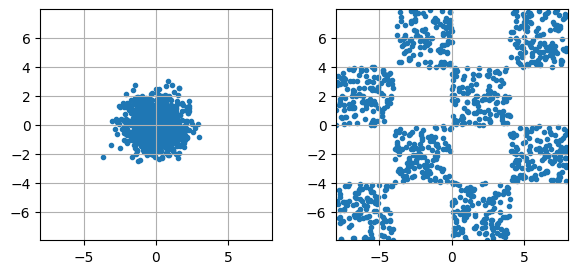

In [6]:
x = p_init.sample(n_samples)
z = p_data.sample(n_samples)

x_min, y_min = reduce([x, z], 'b n d -> d', 'min')
x_max, y_max = reduce([x, z], 'b n d -> d', 'max')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

axes[0].scatter(x[:, 0], x[:, 1], marker='.')
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[0].set_aspect('equal')
axes[0].grid(True)

axes[1].scatter(z[:, 0], z[:, 1], marker='.')
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)
axes[1].set_aspect('equal')
axes[1].grid(True)

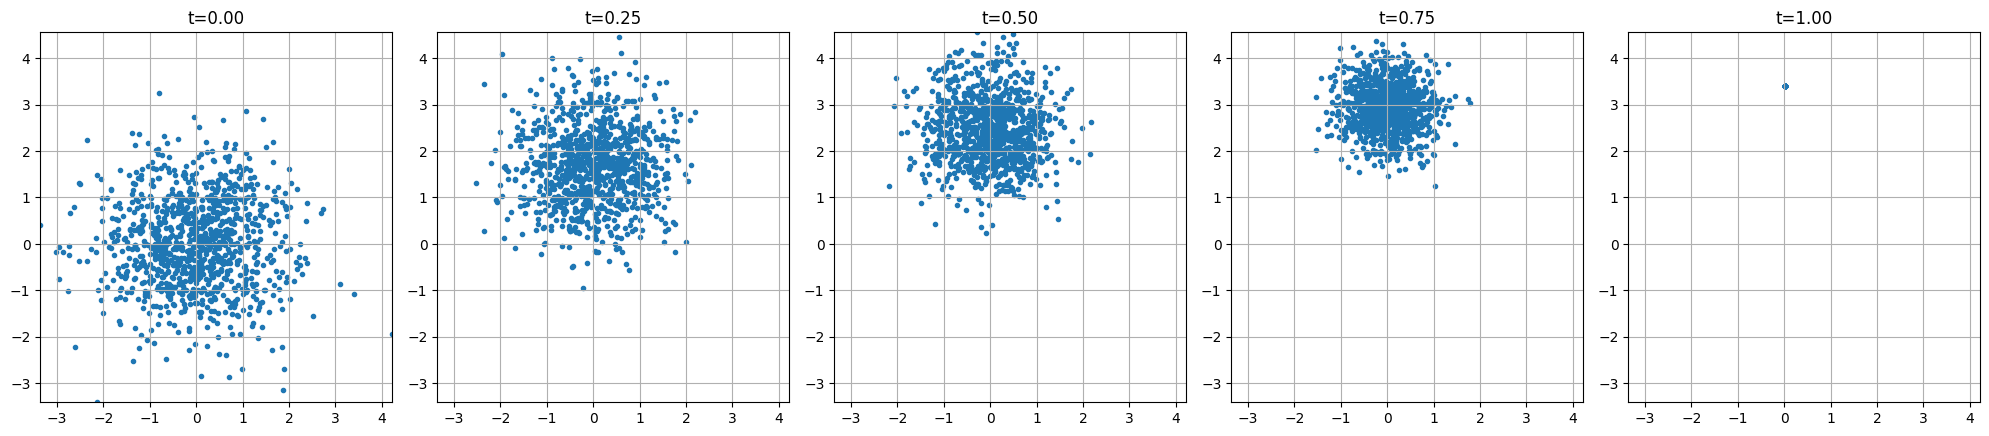

In [7]:
t_steps = torch.linspace(0, 1, steps=n_steps)
t = repeat(t_steps, 't -> (t n) 1', n=n_samples)
z = p_data.sample((1,))
x_t = path.sample_conditional(z, t)
x_t = rearrange(x_t, '(t n) d -> t n d', n=n_samples)
plot_prob_path(x_t, t_steps)

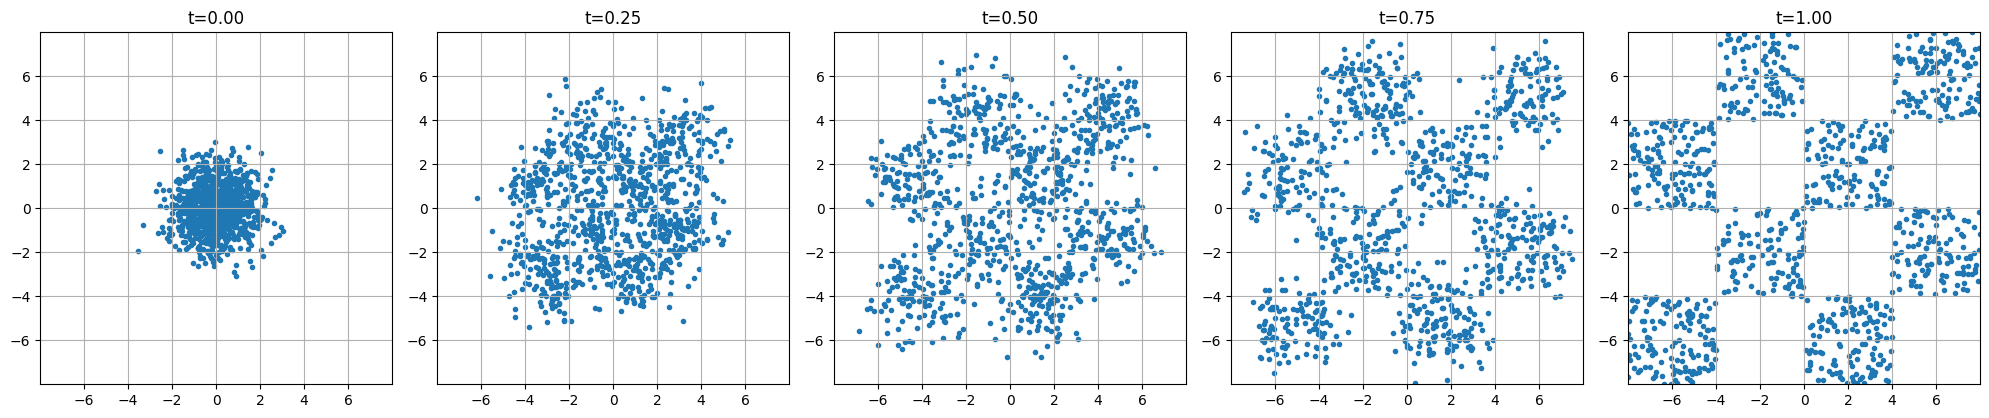

In [8]:
t_steps = torch.linspace(0, 1, steps=n_steps)
t = repeat(t_steps, 't -> (t n) 1', n=n_samples)
x_t = path.sample_marginal(t)
x_t = rearrange(x_t, '(t n) d -> t n d', n=n_samples)
plot_prob_path(x_t, t_steps)

In [9]:
vtf_cond: VectorField = CondGaussVectorField(z=z)
ode_cond: ODE = ODE(vector_field=vtf_cond)
sim_euler: Simulator = EulerSimulator(ode=ode_cond)

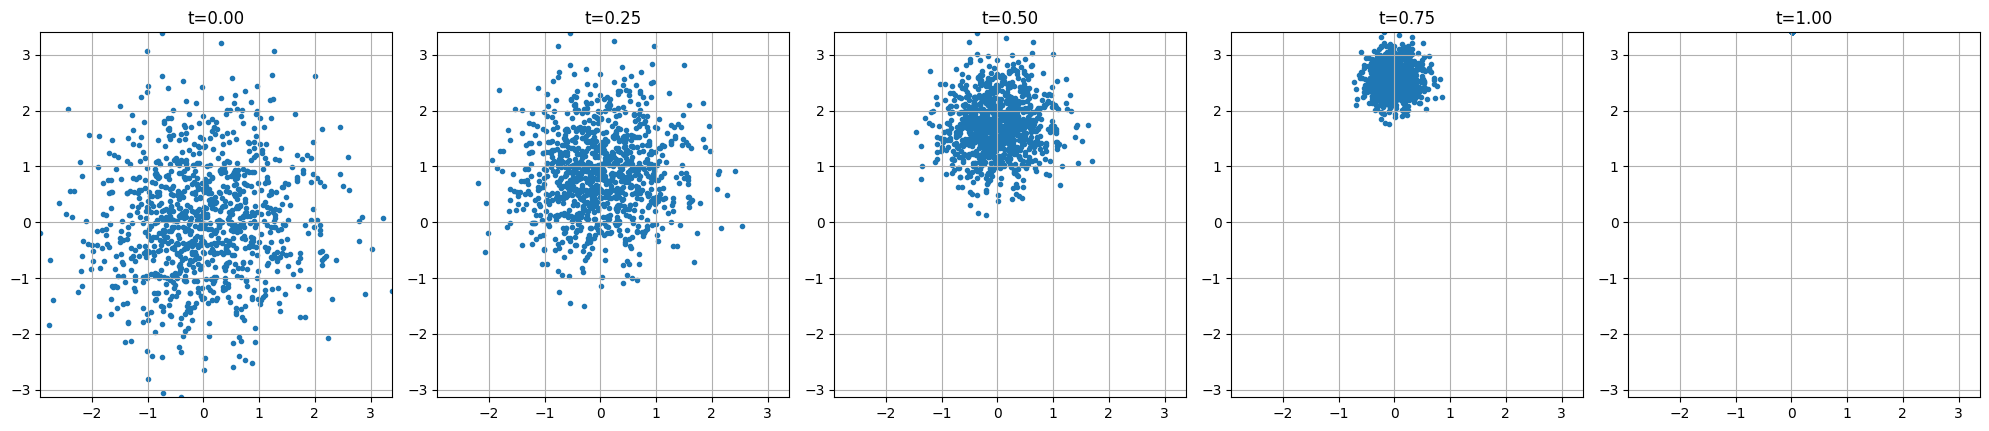

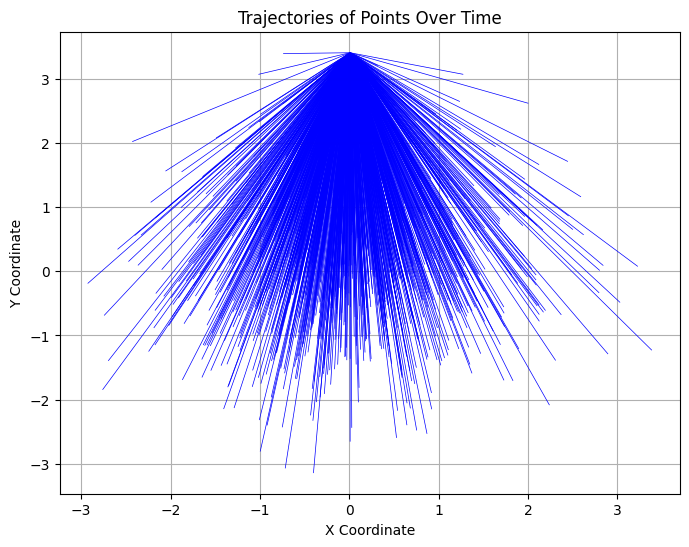

In [10]:
t = torch.linspace(0, 1, 5)
x_0 = p_init.sample(n_samples)
x_t = sim_euler.trajectory(x_0, t)

plot_prob_path(x_t, t)
plot_trajectory(x_t)